Project root added to sys.path: d:\Handwritten Digit Recognition
Epoch 1/3
32/32 - 11s - 356ms/step - accuracy: 0.6765 - loss: 1.1729
Epoch 2/3
32/32 - 4s - 140ms/step - accuracy: 0.9380 - loss: 0.2228
Epoch 3/3
32/32 - 4s - 140ms/step - accuracy: 0.9680 - loss: 0.1157
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step

 Test Accuracy: 0.8868
⏱ Training time: 20.41 sec
⏱ Prediction time: 5.16 sec

 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94       980
           1       0.99      0.95      0.97      1135
           2       0.91      0.94      0.92      1032
           3       0.64      0.99      0.78      1010
           4       0.99      0.81      0.89       982
           5       0.94      0.74      0.83       892
           6       0.97      0.91      0.94       958
           7       0.97      0.87      0.92      1028
           8       0.88      0.77      0.82       974
           9       0.81      0.96      0.87

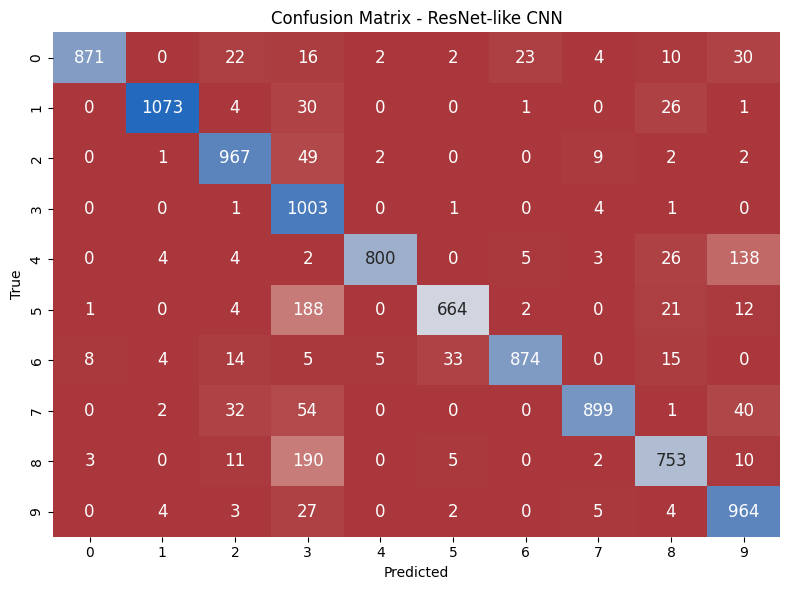

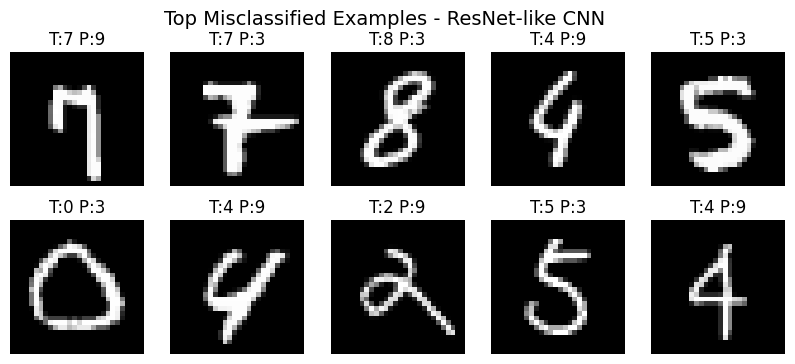

In [1]:
%run ../utils/init_notebook.py

from utils.data_loader import load_mnist
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, Add, Flatten, Dense
)
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Load data (raw pixels, no normalization)
X_train, y_train, X_test, y_test = load_mnist(normalise=False)

# Use smaller subset for faster training
subset_size = 4000
X_train_sub = X_train[:subset_size]
y_train_sub = y_train[:subset_size]

# Reshape for CNN input
X_train_cnn = X_train_sub.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.reshape(-1, 28, 28, 1)

# One-hot encode labels
y_train_cat = to_categorical(y_train_sub, 10)
y_test_cat = to_categorical(y_test, 10)

# Define a simple residual block
def resnet_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# Build ResNet-like model
inputs = Input(shape=(28, 28, 1))
x = Conv2D(32, 3, padding='same', activation='relu')(inputs)
x = resnet_block(x, 16)
x = resnet_block(x, 16)
x = resnet_block(x, 32, stride=2)  # downsample
x = resnet_block(x, 32)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
start_train = time.time()
model.fit(X_train_cnn, y_train_cat, epochs=3, batch_size=128, verbose=2)
end_train = time.time()

# Predict
start_pred = time.time()
y_pred_prob = model.predict(X_test_cnn)
y_pred_resnet = np.argmax(y_pred_prob, axis=1)
end_pred = time.time()

acc_resnet = accuracy_score(y_test, y_pred_resnet)
print(f"\n Test Accuracy: {acc_resnet:.4f}")
print(f"⏱ Training time: {end_train - start_train:.2f} sec")
print(f"⏱ Prediction time: {end_pred - start_pred:.2f} sec")

# Classification report
print("\n Classification Report:")
print(classification_report(y_test, y_pred_resnet))

# Confusion matrix
cm_resnet = confusion_matrix(y_test, y_pred_resnet)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_resnet, annot=True, fmt="d", cmap="vlag_r", cbar=False, annot_kws={"size": 12})
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - ResNet-like CNN")
plt.tight_layout()
plt.show()

# Show misclassified examples
misclassified_idx_resnet = np.where(y_pred_resnet != y_test)[0]
plt.figure(figsize=(10, 4))
for i, idx in enumerate(misclassified_idx_resnet[:10]):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[idx], cmap='gray')
    plt.title(f"T:{y_test[idx]} P:{y_pred_resnet[idx]}")
    plt.axis('off')
plt.suptitle("Top Misclassified Examples - ResNet-like CNN", fontsize=14)
plt.show()

In [2]:
import os
import pandas as pd
import joblib

# Path for accuracy log file
ACC_LOG = "results/model_accuracies.csv"

# Append model name + accuracy
model_name = "ResNet"  

results_dir = os.path.join("..", "results")
os.makedirs(results_dir, exist_ok=True)
results_file = os.path.join(results_dir, "accuracies.csv")

# Append or Create CSV
if os.path.exists(results_file):
    df = pd.read_csv(results_file)
    df = df[["model_name", "accuracy_value"]] if "accuracy_value" in df.columns else pd.DataFrame(columns=["model_name", "accuracy_value"])
else:
    df = pd.DataFrame(columns=["model_name", "accuracy_value"])

# Remove old entry if model already logged (to avoid duplicates)
df = df[df["model_name"] != model_name]

# Add new row
df = pd.concat([df, pd.DataFrame([{
    "model_name": model_name,
    "accuracy_value": acc_resnet
}])], ignore_index=True)

# Save
df.to_csv(results_file, index=False)

# Save model
joblib.dump(model, f"../results/{model_name}.pkl")

print(f"Accuracy logged for model '{model_name}' in {results_file}")
print(f"Model saved as ../results/{model_name}.pkl")

Accuracy logged for model 'ResNet' in ..\results\accuracies.csv
Model saved as ../results/ResNet.pkl
